In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

## Preliminary

Suppose we have the Lagrangian

$$L = \frac{1}{2} m_1 (\dot{x}_1^2+\dot{y}_1^2) +  \frac{1}{2} m_2 (\dot{x}_2^2+\dot{y}_2^2) -m_1gy_1 - m_2gy_2 $$

We can remove some degrees of freedom by dividing by $m_1$ and some characteristic length $A$ of the problem

$$\frac{L}{A^2 m_1} = \frac{1}{2} \left(\left(\dot{\frac{x_1}{A}}\right)^2+\left(\dot{\frac{y_1}{A}}\right)^2 \right) + \frac{1}{2} \frac{m_2}{m_1}\left(\left(\dot{\frac{x_2}{A}}\right)^2+\left(\dot{\frac{y_2}{A}}\right)^2 \right) -\frac{g}{A}\frac{y_1}{A} - \frac{m_2}{m_1}\frac{g}{A}\frac{y_2}{A} $$

This might look more complicated, by defining $m = m_2/m_1$ and putting primes such that $x' = x/A$ we get

$$\frac{L}{A^2 m_1} = \frac{1}{2} (\dot{x'}_1^2+\dot{y'}_1^2) +  \frac{1}{2} m (\dot{x'}_2^2+\dot{y'}_2^2) -g'y_1' - mg'y_2' $$

Note that $\frac{L}{A^2 m_1}$ produces the same equations of motion as $L$ (for any $C$, $CL$ produces the same equations of motion as $L$). Thus we can solve the Lagrangian problem above, and then put in any values of $A$ and $m_1$ we want afterwards, and scale appropriately.

## The Problem

The driven double pendulum with masses $m_1=1$ and $m_2=m$ and arm-lengths $L_1$ and $L_2$ has it upper arm connector to a motor that displaces the base with at $\cos(\omega t)$ where $\omega$ is the driving frequency.

<p align="center">
  <img src="../images/vid15_p1.PNG" alt="drawing" width="300" align="center"/>
</p>

and thus

* $x_1 = \cos(\omega t) + L_1 \sin(\theta_1)$
* $x_2 = \cos(\omega t) + L_1 \sin(\theta_1) + L_2 \sin(\theta_2)$
* $y_1 = -L_1 \cos(\theta_1)$
* $y_2 = -L_1 \cos(\theta_1)-L_2 \cos(\theta_2)$

Define required variables for sympy

In [2]:
t, m, g, L1, L2, w, C, alph, beta = smp.symbols(r't m g L_1, L_2 \omega C \alpha \beta')

Define $\theta_1(t)$ and $\theta_2(t)$ and declare them functions of time. Also get their first and second derivatives.

In [3]:
the1, the2, =  smp.symbols(r'\theta_1, \theta_2 ', cls=smp.Function)

the1 = the1(t)
the1_d = smp.diff(the1, t)
the1_dd = smp.diff(the1_d, t)

the2 = the2(t)
the2_d = smp.diff(the2, t)
the2_dd = smp.diff(smp.diff(the2, t), t)

Declare $x_1(\theta_1)$, $y_1(\theta_1)$ and $x_2(\theta_1, \theta_2)$, $y_2(\theta_1, \theta_2)$

In [4]:
x1, y1, x2, y2 = smp.symbols('x_1, y_1, x_2, y_2', cls=smp.Function)
x1= x1(t, the1)
y1= y1(t, the1)
x2= x2(t, the1, the2)
y2= y2(t, the1, the2)

Put in the specific functional form of $x_1$, $y_1$, $x_2$, $y_2$

In [5]:
x1 = smp.cos(w*t)+L1*smp.sin(the1)
y1 = -L1*smp.cos(the1)
x2 = smp.cos(w*t)+L1*smp.sin(the1) + L2*smp.sin(the2)
y2 = -L1*smp.cos(the1) -L2*smp.cos(the2)

Define numerical functions for $v_{x1}$, $v_{y1}$, $v_{x2}$, $v_{y1}$

In [6]:
smp.diff(x1, t)

L_1*cos(\theta_1(t))*Derivative(\theta_1(t), t) - \omega*sin(\omega*t)

In [7]:
vx1_f = smp.lambdify((t,w,L1,L2,the1,the2,the1_d,the2_d), smp.diff(x1, t))
vx2_f = smp.lambdify((t,w,L1,L2,the1,the2,the1_d,the2_d), smp.diff(x2, t))
vy1_f = smp.lambdify((t,w,L1,L2,the1,the2,the1_d,the2_d), smp.diff(y1, t))
vy2_f = smp.lambdify((t,w,L1,L2,the1,the2,the1_d,the2_d), smp.diff(y2, t))

Define kinetic energy $T$, potential energy $V$, and Lagrangian $L=T-V$

In [8]:
T = 1/2 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2) + \
    1/2 * m  *(smp.diff(x2, t)**2 + + smp.diff(y2, t)**2)
V = g*y1 + m*g*y2
L = T-V

Solve Lagranges Equations

$$\frac{\partial L}{ \partial \theta} - \frac{d}{dt}\frac{\partial L}{ \partial \dot{\theta}} = 0$$

In [9]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t)
LE1 = LE1.simplify()

LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t)
LE2 = LE2.simplify()

In [10]:
LE1

1.0*L_1*(-L_1*m*Derivative(\theta_1(t), (t, 2)) - L_1*Derivative(\theta_1(t), (t, 2)) - L_2*m*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 - L_2*m*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + \omega**2*m*cos(\omega*t)*cos(\theta_1(t)) + \omega**2*cos(\omega*t)*cos(\theta_1(t)) - g*m*sin(\theta_1(t)) - g*sin(\theta_1(t)))

In [11]:
LE2

1.0*L_2*m*(L_1*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)**2 - L_1*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), (t, 2)) - L_2*Derivative(\theta_2(t), (t, 2)) + \omega**2*cos(\omega*t)*cos(\theta_2(t)) - g*sin(\theta_2(t)))

Since these are both equal to zero and linear in terms of $\partial_t^2 \theta_1$ and $\partial_t^2 \theta_2$, we can solve for everything in terms of $\partial_t^2 \theta_1$ and $\partial_t^2 \theta_2$ (this gives us two coupled second order ODEs)

In [12]:
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),
                simplify=False, rational=False)

sols[the1_dd] #d^2 / dt^2 theta_1

L_1*m*sin(\theta_1(t) - \theta_2(t))*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)**2/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) + L_2*m*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) + \omega**2*m*cos(\omega*t)*cos(\theta_1(t) - \theta_2(t))*cos(\theta_2(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) - \omega**2*m*cos(\omega*t)*cos(\theta_1(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) - \omega**2*cos(\omega*t)*cos(\theta_1(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) + g*m*sin(\theta_1(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) - g*m*sin(\theta_2(t))*cos(\theta_1(t) - \theta_2(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1) + g*sin(\theta_1(t))/(L_1*m*cos(\theta_1(t) - \theta_2(t))**2 - L_1*m - L_1)

Can we find driving frequencies that result in resonance. For simplicity:

* Assume small angle approximation for $\theta_1$ and $\theta_2$
* Assume $\theta_1$ and $\theta_2$ have solutions $\theta_1(t) = C\cos(\omega t)$ and $\theta_2(t) = C \alpha \cos(\omega t)$

In [13]:
LE1

1.0*L_1*(-L_1*m*Derivative(\theta_1(t), (t, 2)) - L_1*Derivative(\theta_1(t), (t, 2)) - L_2*m*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 - L_2*m*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + \omega**2*m*cos(\omega*t)*cos(\theta_1(t)) + \omega**2*cos(\omega*t)*cos(\theta_1(t)) - g*m*sin(\theta_1(t)) - g*sin(\theta_1(t)))

In [14]:
a = LE1.subs([(smp.sin(the1-the2), the1-the2),
         (smp.cos(the1-the2), 1),
         (smp.cos(the1), 1),
         (smp.sin(the1), the1),
         (the1, C*smp.cos(w*t)),
         (the2, C*alph*smp.cos(w*t)),
         (m, 1),
         (L2, L1),
         ]).doit().series(C, 0, 2).removeO().simplify()

In [15]:
b = LE2.subs([(smp.sin(the1-the2), the1-the2),
         (smp.cos(the1-the2), 1),
         (smp.cos(the1), 1),
         (smp.cos(the2), 1),
         (smp.sin(the1), the1),
         (smp.sin(the2), the2), 
         (the1, C*smp.cos(w*t)),
         (the2, C*alph*smp.cos(w*t)),
         (m, 1),
         (L2, L1),
         ]).doit().series(C, 0, 2).removeO().simplify()

In [16]:
yeet = smp.solve([a.args[1], b.args[2]], (w, alph))

In [17]:
yeet[2][0]

-sqrt(-C*g*(-2.0 + 1.4142135623731*(C**2*L_1**2 + C*L_1 + 0.5)**0.5/(C*L_1) - 1/(C*L_1))/(C*L_1 + 1.0))

Now set $\beta = CL_1$ and take the limit as $\beta \to \infty$.

In [18]:
yeet[0][0]

-sqrt(-C*g*(-2.0 - 1.4142135623731*(C**2*L_1**2 + C*L_1 + 0.5)**0.5/(C*L_1) - 1/(C*L_1))/(C*L_1 + 1.0))

In [19]:
smp.limit(yeet[1][0].subs(C, beta/L1).simplify(), beta, smp.oo)

3*sqrt(37935706248590)*sqrt(g/L_1)/10000000

# Switch to Numerical

Define the equations

* $\frac{d^2 \theta}{dt^2} = \frac{d \zeta}{dt} = \text{solution to above}$
* $\frac{d \theta}{dt} = \zeta$

for each of $\theta \in (\theta_1, \theta_2)$

In [20]:
dz1dt_f = smp.lambdify((t, m, g, w, L1, L2, the1, the2, the1_d, the2_d), sols[the1_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)

dz2dt_f = smp.lambdify((t, m, g, w, L1, L2, the1, the2, the1_d, the2_d), sols[the2_dd])
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Define the ODE system for python $ S = (\theta_1, \zeta_1, \theta_2, \zeta_2)$

In [21]:
def dSdt(S, t):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, m, g, w, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, m, g, w, L1, L2, the1, the2, z1, z2),
    ]

Some numerical values to get a solution

In [22]:
t = np.linspace(0, 20, 1000)
g = 9.81
m=1
L1 = 20
L2 = 20
w = np.sqrt(g/L1)
ans = odeint(dSdt, y0=[0, 0, 0, 0], t=t)

Plot $\theta_1(t)$

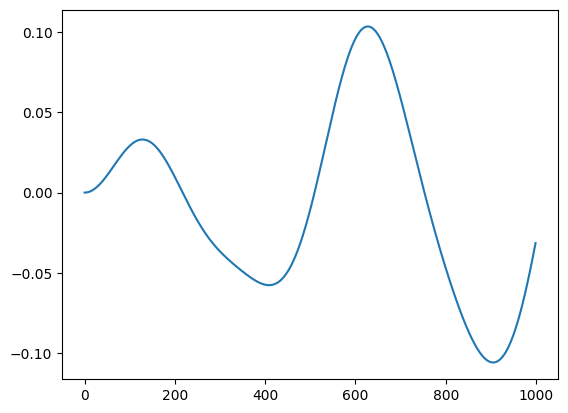

In [23]:
plt.plot(ans.T[0])

Function that computes the average kinetic energy (assuming $m=1$) of the system given by

$$E(\omega) = \text{Mean}(v_{x1}^2 + v_{y1}^2 + v_{x2}^2 + v_{y2}^2) $$

where the $v$'s are computed by solving the ODE for a number of time points for a specific value of $\omega$

In [24]:
def get_energy(w):
    t = np.linspace(0, 100, 2000)
    ans = odeint(dSdt, y0=[0.1, 0.1, 0, 0], t=t)
    vx1 = vx1_f(t,w,L1,L2,ans.T[0],ans.T[2],ans.T[1],ans.T[3])
    vx2 = vx2_f(t,w,L1,L2,ans.T[0],ans.T[2],ans.T[1],ans.T[3])
    vy1 = vy1_f(t,w,L1,L2,ans.T[0],ans.T[2],ans.T[1],ans.T[3])
    vy2 = vy2_f(t,w,L1,L2,ans.T[0],ans.T[2],ans.T[1],ans.T[3])
    E = 1/2 * np.mean(vx1**2+vx2**2+vy1**2+vy2**2)
    return E

Get $\omega$'s and $E(\omega)$

In [25]:
ws = np.linspace(0.4, 1.3, 100)
Es = np.vectorize(get_energy)(ws) 

Plot the kinetic energy of the system for different values of $\omega$

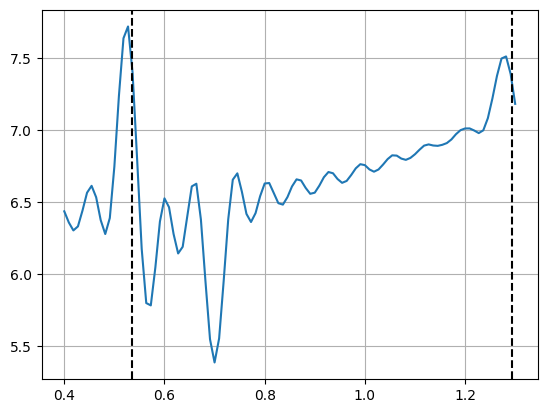

In [26]:
plt.plot(ws, Es)
plt.axvline(1.84775*np.sqrt(g/L1), c='k', ls='--')
plt.axvline(0.76536*np.sqrt(g/L1), c='k', ls='--')
# Tautochrone
#plt.axvline(np.sqrt(np.pi*g**(-1/2)), c='k', ls='--')
plt.grid()

Solve the ODE for a particular value of $\omega$ so we can ge the solution. Also define a function that takes in $\theta_1(t), \theta_2(t)$ and returns the corresponding $x$ and $y$ values of the origin, first bob, and second bob.

In [27]:
t = np.linspace(0, 200, 20000)
g = 9.81
m=1
L1 = 20
L2 = 20
w = ws[ws>1][np.argmax(Es[ws>1])]
ans = odeint(dSdt, y0=[0.1, 0.1, 0, 0], t=t)

def get_x0y0x1y1x2y2(t, the1, the2, L1, L2):
    return (np.cos(w*t),
            0*t,
            np.cos(w*t) + L1*np.sin(the1),
            -L1*np.cos(the1),
            np.cos(w*t) + L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2),
    )

x0, y0, x1, y1, x2, y2 = get_x0y0x1y1x2y2(t, ans.T[0], ans.T[2], L1, L2)

Make an animation

C:\Users\fangy\AppData\Local\Temp\ipykernel_26636\3713599270.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ln2, = ax.plot([], [], 'ro-',markersize = 8, alpha=0.05, color='cyan')   # line for Earth
C:\Users\fangy\AppData\Local\Temp\ipykernel_26636\3713599270.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ln3, = ax.plot([], [], 'ro-',markersize = 8,alpha=0.05, color='cyan')


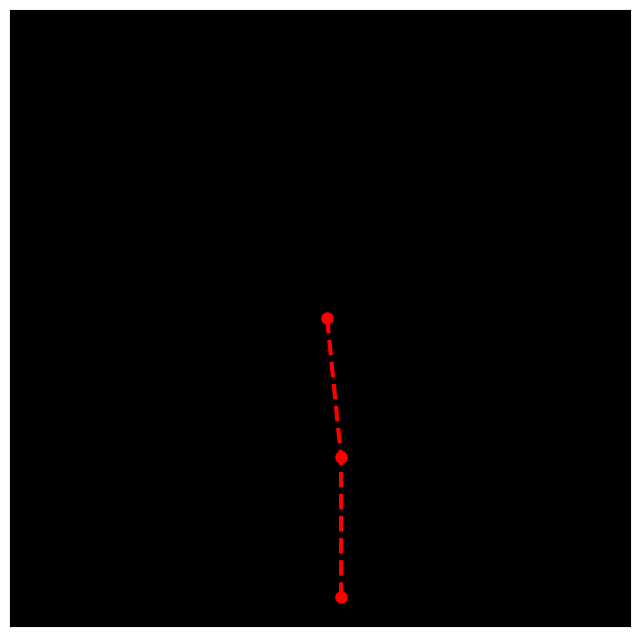

In [29]:
def animate(i):
    ln1.set_data([x0[::10][i], x1[::10][i], x2[::10][i]], [y0[::10][i], y1[::10][i], y2[::10][i]])
    trail1 = 50            # length of motion trail of weight 1 
    trail2 = 50            # length of motion trail of weight 2
    ln2.set_data(x1[::10][i:max(1,i-trail1):-1], y1[::10][i:max(1,i-trail1):-1])   # marker + line of first weight
    ln3.set_data(x2[::10][i:max(1,i-trail2):-1], y2[::10][i:max(1,i-trail2):-1])   # marker + line of the second weight
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ln2, = ax.plot([], [], 'ro-',markersize = 8, alpha=0.05, color='cyan')   # line for Earth
ln3, = ax.plot([], [], 'ro-',markersize = 8,alpha=0.05, color='cyan')
ax.set_ylim(-44,44)
ax.set_xlim(-44,44)
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=50)
ani.save('images/pen2.gif',writer='ffmpeg',fps=50)